In [1]:
import pandas as pd
import re
import numpy as np

data = pd.read_pickle('../../data/trojans_dataset.pkl')

## Pre Processing

In [234]:
cols = ['crc32', 'urls','static.pe.imported_dll_count','exiftool.EXE-CodeSize',
        'exiftool.File-FileSize','die.library','die.compiler','die.linker','exiftool.EXE-CharacterSet',
        'exiftool.EXE-ObjectFileType', 'exiftool.EXE-LegalCopyright','exiftool.EXE-FileDescription',
        'vt.total_scans']
data[cols].head(10)

,crc32,urls,static.pe.imported_dll_count,exiftool.EXE-CodeSize,exiftool.File-FileSize,die.library,die.compiler,die.linker,exiftool.EXE-CharacterSet,exiftool.EXE-ObjectFileType,exiftool.EXE-LegalCopyright,exiftool.EXE-FileDescription,vt.total_scans
0,1BA5D135,[],0.0,570880,2.4 MB,NaN,NaN,Microsoft Linker(11.0)[EXE32],NaN,NaN,NaN,NaN,68.0
1,49851D2F,[],1.0,116736,201 kB,NaN,Microsoft Visual C/C++(2008 SP1)[libcmt],Microsoft Linker(9.0)[EXE32],NaN,NaN,NaN,NaN,65.0
2,E0774FB9,[],0.0,13824,36 kB,NaN,Microsoft Visual C/C++(2008 SP1)[-],Microsoft Linker(9.0)[DLL32],NaN,NaN,NaN,NaN,NaN
3,6E8CAC13,[],10.0,389120,459 kB,NaN,Borland C++(Builder)[-],Turbo Linker(5.0)[EXE32],NaN,NaN,NaN,NaN,68.0
4,B3191AD1,[],0.0,260608,288 kB,NaN,Microsoft Visual C/C++(2008 SP1)[-],"Microsoft Linker(9.0)[DLL32,console]",NaN,NaN,NaN,NaN,NaN
5,9CF3E88A,[http://cache-download.real.com/free/windows/i...,0.0,660480,1104 kB,NaN,NaN,Microsoft Linker(10.0)[EXE32],NaN,NaN,NaN,NaN,NaN
6,B476670A,[http://www.mozilla.org/editor/midasdemo/secur...,40.0,10261504,13 MB,NaN,Embarcadero Delphi(XE2-XE6)[-],"Turbo Linker(2.25*,Delphi)[EXE32]","Windows, Latin1",Executable application,NaN,NaN,62.0
7,BF296A23,"[http://lame.sf.net, http://www.openssl.org/su...",15.0,1247232,2.6 MB,NaN,"Microsoft Visual C/C++(2008)[libcmt,wWinMain]",Microsoft Linker(9.0)[EXE32],NaN,NaN,NaN,NaN,63.0
8,9EF6D7FD,[],0.0,93696,128 kB,NaN,Microsoft Visual C/C++(2008 SP1)[-],Microsoft Linker(9.0)[DLL32],NaN,NaN,NaN,NaN,NaN
9,3ABEE28F,[http://ts-crl.ws.symantec.com/tss-ca-g2.crl0(...,3.0,2048,16 kB,NaN,Microsoft Visual C/C++(2010 SP1)[-],"Microsoft Linker(10.0)[EXE64,console,signed]",Unicode,Executable application,Copyright © 2015,Java(TM) Platform SE binary,NaN


In [2]:
data['CRC'] = data['crc32'].apply(lambda x: int(x,32))

#### Column 'urls':
<u>Description:</u> contains an array of urls accessed by the program file<br>
<u>Action:</u> create a new feature that tells if the program file request urls or not

In [3]:
data['HasUrls'] = data['urls'].apply(lambda x: len(x)>0)

#### Column 'static.pe.imported_dll_count':
<u>Description:</u> number of dlls used on file<br>
<u>Action:</u> fill missing values with the mean of dlls

In [4]:
mean = data['static.pe.imported_dll_count'].mean()
data['DLL_COUNT'] = data['static.pe.imported_dll_count'].fillna(mean).astype(int)

#### Column 'exiftool.EXE-CodeSize':
<u>Description:</u> size of file source code<br>
<u>Action:</u> fill missing values with the mean value

In [5]:
mean = data['exiftool.EXE-CodeSize'].astype(float).mean()
data['CodeSize'] = data['exiftool.EXE-CodeSize'].fillna(mean).astype(int)

#### Column 'exiftool.File-FileSize':
<u>Description:</u> file size<br>
<u>Action:</u> create a magnitude order of size as: bytes, kB, MB, large

In [235]:
def size_extract(x):
    number, order = x.split()
    if((float(number)>100) & (order=='MB')):
        order = 'large'
    return order

data['FileSize'] = data['exiftool.File-FileSize'].apply(size_extract).astype('category')

#### Columns 'die.library', 'die.compiler', 'die.linker':
<u>Description:</u> tells the library, compiler e linker used to create the file<br>
<u>Action:</u> create categories for these columns

In [236]:
data['Library'] = data['die.library'].fillna('unknown') \
                .astype('str').apply(lambda x: re.sub(r'\(.*','',x.lower())).astype('category')

In [57]:
data['Compiler'] = data['die.compiler'].fillna('unknown') \
                .astype('str').apply(lambda x: re.sub(r'\(.*','',x.lower())).astype('category')

In [237]:
data['Linker'] = data['die.linker'].fillna('unknown') \
                .astype('str').apply(lambda x: re.sub(r'\(.*','',x.lower())).astype('category')

In [241]:
# Example of categories
data['Linker'].value_counts()

microsoft linker    14077
unknown              3612
turbo linker         1572
gnu linker            691
polink                 40
lcc linker              5
watcom linker           2
borland tlink           1
Name: Linker, dtype: int64

#### Columns 'exiftool.EXE-CharacterSet':
<u>Description:</u> charset type<br>
<u>Action:</u> create categories for this column

In [242]:
def charset(x):
    if ((x!='Unicode') & (x!='Windows, Latin1') & (x!='ASCII')):
        x = 'Other'
    return x
data['CharSet'] = data['exiftool.EXE-CharacterSet'].apply(charset).fillna('Other').astype('category')

In [243]:
# Example of charset categories
data.CharSet.value_counts()

Other              15544
Unicode             3605
Windows, Latin1      803
ASCII                 48
Name: CharSet, dtype: int64

#### Columns 'exiftool.EXE-ObjectFileType':
<u>Description:</u> file type<br>
<u>Action:</u> create categories for this column

In [245]:
data['FileType'] = data['exiftool.EXE-ObjectFileType'].fillna('Unknown').astype('category')

In [247]:
# Example of filetype categories
data.FileType.value_counts()

Unknown                   15632
Executable application     3430
Dynamic link library        888
Driver                       47
Static library                3
Name: FileType, dtype: int64

#### Columns 'exiftool.EXE-LegalCopyright', 'exiftool.EXE-FileDescription':
<u>Description:</u> shows copyright and a description of the file<br>
<u>Action:</u> create a boolean telling if the file has copyright/description

In [248]:
data['HasCopyright'] = data['exiftool.EXE-LegalCopyright'].isnull() == False

In [249]:
data['HasDescription'] = data['exiftool.EXE-FileDescription'].isnull() == False

#### Columns 'vt.total_scans':
<u>Description:</u> this column contains the number of anti virus scans that told if it is a virus.
<b>It will be our target for this model</b><br>
<u>Action:</u> create boolean if it is a virus or not

In [64]:
data['IsMalware']  = (data['vt.total_scans'] >= 50).astype(int)

### Feature Extraction

In [ ]:
items = ['HasUrls',
         #'CRC',
         'DLL_COUNT',
         'CodeSize',
         'FileSize',
#          'mss_coordinates.BawaneH',
#          'mss_coordinates.MultiEncryptWinDLL',
#          'mss_coordinates.Sayonara',
#          'mss_coordinates.WhatsappSLDLL',         
         'Library',
         'Compiler',
         'Linker',
         'CharSet',
         'FileType',
         'HasCopyright',
         'HasDescription',
         'IsMalware'
        ]

In [195]:
data_fil = data.filter(items)
data_fil.drop_duplicates(inplace=True)

#### Encoding the labels of our categoricals columns

In [196]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

categoricals = ['FileSize', 'Library', 'Compiler', 'Linker', 'CharSet', 'FileType']
for cat in categoricals:
    data_fil[cat] = enc.fit_transform(data_fil['FileSize'])


#### Standardize numerical features by removing the mean and scaling to unit variance

In [199]:
from sklearn.preprocessing import StandardScaler
numbers = ['DLL_COUNT','CodeSize']#,'mss_coordinates.BawaneH','mss_coordinates.MultiEncryptWinDLL','mss_coordinates.Sayonara','mss_coordinates.WhatsappSLDLL']
sc = StandardScaler()
data_fil[numbers] = sc.fit_transform(data_fil[numbers])

## Creating model - Random Forest

The model chosen for this problem is random forest, since it is a good approach when dealing with categorical variables

First of all, we will see the proportion of virus and non-virus in our dataset:

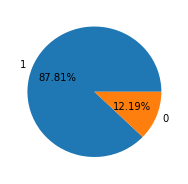

In [252]:
import matplotlib.pyplot as plt
%matplotlib inline

data_fil['IsMalware'].value_counts().plot(
    kind='pie', autopct='%.2f%%', figsize=(3, 3), label='')

Since the majority of our dataset is of virus types, we will use two approaches as seen in Using Random Forest to Learn Imbalanced Data article(by Chao Chen and Leo Breiman). Link: http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf.

The first one is the Weighted Random Forest, and for this we will use the sklearn library and its hyperparam class-weight, this method will penalized more the error when guessing wrong non-virus(minority class).

The second will be the Balanced Random Forest. For this we will create lots of non-pruned trees with reduced balanced samples of our dataset and aggregates the predictions of the ensemble to make the final prediction.

#### Model Split

The model will be split in a ratio of 80% for training and 20% for testing. Since our dataset is small it will not be used any cross validation.

In [306]:
features = data_fil.columns.drop('IsMalware')

train_set = data_fil.sample(frac=0.8)
test_set = data_fil.loc[data_fil.index.isin(train_set.index)==False]

In [307]:
train_set = train_set.reset_index().drop('index', axis=1)
test_set = test_set.reset_index().drop('index', axis=1)

#### Weighted Random Forest

In [374]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

wrf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced', max_depth=10)
X_train = train_set[features].values
y_train = train_set.IsMalware.values
wrf.fit(X_train,y_train)
y_pred_train = wrf.predict(X_train)

print('Train ACC: {}'.format(accuracy_score(y_train,y_pred_train)))

Train ACC: 0.8518157445771387


In [375]:
X_test = test_set[features].values
y_test = test_set.IsMalware.values
y_pred_test = wrf.predict(X_test)

print('Test ACC: {}'.format(accuracy_score(y_test,y_pred_test)))

Test ACC: 0.8021442495126706


#### Balanced Random Forest

In [378]:
from sklearn.tree import DecisionTreeClassifier

trees = []

for i in range(300):
    minority = train_set.loc[train_set['IsMalware']==0]
    n = minority.shape[0]
    majority = train_set.loc[train_set['IsMalware']==1].sample(n,replace=True)

    df = pd.concat([minority,majority]).reset_index().drop('index', axis=1)
    
    dt = DecisionTreeClassifier(max_features=5)
    
    X = df[features].values
    y = df['IsMalware'].values
    dt.fit(X,y)
    trees.append(dt)


In [387]:
X_train = train_set[features].values
y_train = train_set.IsMalware.values
y_proba = np.zeros((y_train.shape[0],300))

for i in range(300):
    y_proba[:,i] = trees[i].predict_proba(X_train)[:,1]

y_proba = y_proba.sum(axis=1)/300
y_pred_train = np.around(y_proba)

print('Train ACC: {}'.format(accuracy_score(y_train,y_pred_train)))

Train ACC: 0.7650499634413843


In [386]:
X_test = test_set[features].values
y_test = test_set.IsMalware.values
y_proba = np.zeros((y_test.shape[0],300))

for i in range(300):
    y_proba[:,i] = trees[i].predict_proba(X_test)[:,1]

y_proba = y_proba.sum(axis=1)/300
y_pred_test = np.around(y_proba)

print('Test ACC: {}'.format(accuracy_score(y_test,y_pred_test)))

Test ACC: 0.672514619883041
